In [1]:
using LinearAlgebra
using ForwardDiff
using FFTW

In [31]:
struct phonycomplex{T<:Real} <:Number
    re::T
    im::T
end
import Base: +,*,-,/, angle, real, imag, abs, abs2

+(a::phonycomplex, b::phonycomplex) = phonycomplex(a.re + b.re, a.im + b.im)
+(a::phonycomplex, b::Real) = phonycomplex(a.re + b, a.im)
+(a::Real, b::phonycomplex) = phonycomplex(b.re + a, b.im)
*(a::phonycomplex, b::phonycomplex) = phonycomplex(a.re * b.re - a.im * b.im, a.re * b.im + a.im * b.re)
*(a::phonycomplex, b::Real) = phonycomplex(a.re * b, a.im * b)
*(a::Real, b::phonycomplex) = phonycomplex(a * b.re, a * b.im)
-(a::phonycomplex) = phonycomplex(-a.re, -a.im)
-(a::phonycomplex, b::phonycomplex) = phonycomplex(a.re - b.re, a.im - b.im)
-(a::phonycomplex, b::Real) = phonycomplex(a.re - b, a.im)
-(a::Real, b::phonycomplex) = phonycomplex(-b.re + a, -b.im)
/(a::phonycomplex, b::phonycomplex) = phonycomplex((a.re * b.re + a.im * b.im) / (b.re^2 + b.im^2), (a.im * b.re - a.re * b.im) / (b.re^2 + b.im^2))
/(a::phonycomplex, b::Real) = phonycomplex(a.re / b, a.im / b)
/(a::Real, b::phonycomplex) = phonycomplex(a * b.re / (b.re^2 + b.im^2), -a * b.im / (b.re^2 + b.im^2))
angle(a::phonycomplex) = atan(a.im, a.re)
# angle(a::phonycomplex{T}) where {T<:Number} = atan(a.im, a.re)
real(a::phonycomplex) = a.re
imag(a::phonycomplex) = a.im
abs(a::phonycomplex) = sqrt(a.re^2 + a.im^2)
abs2(a::phonycomplex) = a.re^2 + a.im^2
# additive / multiplicative identities
Base.zero(::Type{phonycomplex{T}}) where {T} = phonycomplex(zero(T), zero(T))
Base.one( ::Type{phonycomplex{T}}) where {T} = phonycomplex(one(T),  zero(T))

# promotion so that 3 + phonycomplex(1,2) works
Base.promote_rule(::Type{phonycomplex{T}}, ::Type{S}) where {T,S<:Real} =
    phonycomplex{promote_type(T,S)}
phonycomplex(x::Real) = phonycomplex(x, zero(x))   # convenience
Base.convert(::Type{phonycomplex{T}}, x::Real) where {T<:Real} =
    phonycomplex(convert(T,x), zero(T))

phonycomplex(a::Real, b::Real) = phonycomplex(promote(a, b)...)

phonycomplex

In [3]:
function fft_1dcustom(input_re::AbstractVector{T}, 
                    input_im::AbstractVector{T}) where T<:Real
    x_re = copy(input_re)
    x_im = copy(input_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return phonycomplex.(x_re, x_im)
end
function fft_2dcustom(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft_1dcustom(view(real.(B), :, x), view(imag.(B), :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft_1dcustom(view(real.(B), y, :), view(imag.(B), y, :))
    end
    return B
end
function ifft_1dcustom(input_re::AbstractVector{T}, 
                    input_im::AbstractVector{T}) where T<:Real
    x_re = copy(input_re)
    x_im = copy(input_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = 2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return @. phonycomplex(x_re/N, x_im/N)
end
function ifft_2dcustom(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = ifft_1dcustom(view(real.(B), :, x), view(imag.(B), :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = ifft_1dcustom(view(real.(B), y, :), view(imag.(B), y, :))
    end
    return B
end
function custom_fftshift2d(A::AbstractMatrix)
    n1, n2 = size(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
    return A[idx1, idx2]
end
# function custom_ifftshift2d(A::AbstractMatrix)
#     n1, n2 = size(A)
#     idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
#     idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
#     return A[idx1, idx2]
# end


custom_fftshift2d (generic function with 1 method)

In [4]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end
function custom_fftnshift(A::AbstractMatrix{<:phonycomplex})
    B = copy(A)
    return custom_fftshift2d(fft_2dcustom(custom_fftshift2d(B)))
end
function custom_ifftnshift(A::AbstractMatrix{<:phonycomplex})
    B = copy(A)
    return custom_fftshift2d(ifft_2dcustom(custom_fftshift2d(B)))
end

custom_ifftnshift (generic function with 1 method)

In [5]:
test_1 = 1.5 + 2.1im
fake_1 = phonycomplex(1.5, 2.1)
test_2 = 3.0 + 4.0im
fake_2 = phonycomplex(3.0, 4.0)
println("fake: ", fake_1 * fake_2)
println("test: ", test_1 * test_2)
println("fake: ", fake_1 + fake_2)
println("test: ", test_1 + test_2)
println("fake: ", fake_1/ fake_2)
println("test: ", test_1 / test_2)
# println("test: ", test_1 / fake_2)

fake: phonycomplex{Float64}(-3.9000000000000004, 12.3)
test: -3.9000000000000004 + 12.3im
fake: phonycomplex{Float64}(4.5, 6.1)
test: 4.5 + 6.1im
fake: phonycomplex{Float64}(0.516, 0.012000000000000028)
test: 0.516 + 0.012000000000000028im


In [6]:
fake_1 = phonycomplex(1.0, 0.0)

phonycomplex{Float64}(1.0, 0.0)

In [7]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    E₀ = 511.0 #keV
    return hc/sqrt(E*(2*E₀ + E))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

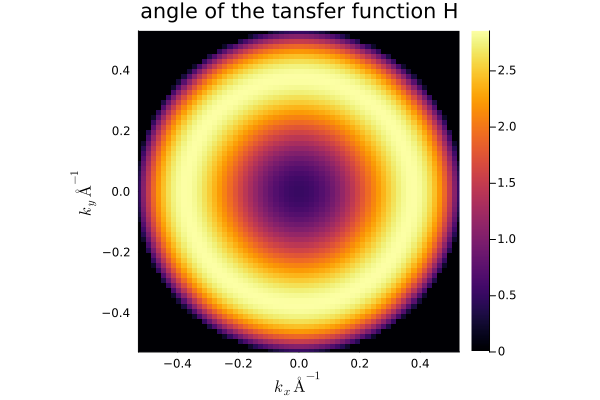

In [8]:
using LaTeXStrings
using Plots
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms
λ_const = Wavelength(E)
N = 2^6


upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2
disk = Float64.(disk)

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
H(r) = @. r[1]*cis(r[2])*exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H([1,0.5])), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

(4096, 1)


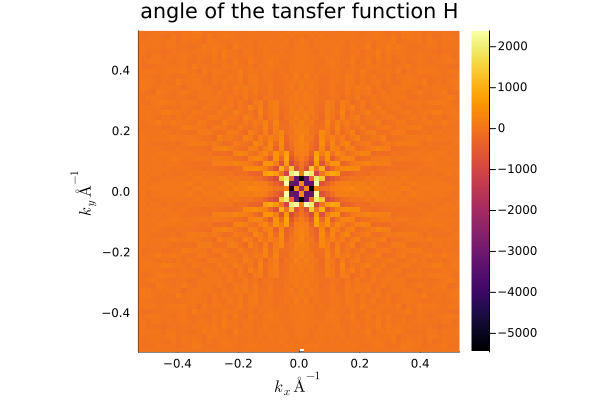

In [33]:
H_fake(r) = abs.(custom_fftnshift(@. phonycomplex(2*r*cos(r-χ(k)*disk)*disk, sin(-χ(k)*disk)*disk)));
# H_fake_angle(r) = angle.(H_fake(r))
H_fake_angle_jacobian(r) = ForwardDiff.jacobian(x -> H_fake(x), [r])
println(size(H_fake_angle_jacobian(1.0)))
# H_fake_diff(r) = ForwardDiff.gradient(x-> H_fake(x), r)
heatmap(kx, ky, H_fake_angle_jacobian(5.0), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

In [10]:
function H_fake_jacobian(r::Vector{Float64})
    # Compute the Jacobian for the real and imaginary parts of H_fake.
    return ForwardDiff.jacobian(x -> [real(H_fake(x)), imag(H_fake(x))], r)
end

# Example usage:
r = [1.0]
J(r) = H_fake_jacobian(r)
println("Jacobian:")
# println(J)
# println("Jacobian shape: ", size(J))
# heatmap(kx, ky, angle.(H_fake_diff([1,0.1])), title="angle of the tansfer function H",  
#         xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
# xlims!(kx[1], kx[end])
# ylims!(ky[1], ky[end])

Jacobian:


In [11]:
# size(J[1])
# size(J[2])
println(size(J([1.0])[1]))
J([0.1])[2][30,30]

MethodError: MethodError: no method matching phonycomplex(::ForwardDiff.Dual{ForwardDiff.Tag{var"#13#14", Float64}, Float64, 1}, ::Float64)
The type `phonycomplex` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  phonycomplex(::Real)
   @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:33
  phonycomplex(::T, !Matched::T) where T<:Real
   @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:2
  (::Type{T})(::T) where T<:Number
   @ Core boot.jl:900
  ...


In [12]:
test_fun(r) = phonycomplex(r[1]^2 + r[2]*r[3], sin(r[1])*r[2]+r[3]^2)
J_test(r) = ForwardDiff.jacobian(r -> [real(test_fun(r)), imag(test_fun(r))], r)
println("Test Jacobian:")
println(J_test([1.0, 0.0,1.0]))

Test Jacobian:
[2.0 1.0 0.0; 0.0 0.8414709848078965 2.0]


In [13]:
test2_fun(r) = abs(phonycomplex(r[1]^2 + r[2]*r[3], sin(r[1])*r[2]+r[3]^2))
J2_test(r) = ForwardDiff.gradient(r->test2_fun(r), r)
J2_test([1.0, 0.0,1.0])

3-element Vector{Float64}:
 1.414213562373095
 1.3021166207159334
 1.414213562373095

In [14]:
H_fake_fft = custom_ifftnshift(custom_fftnshift(H_fake))
heatmap(kx, ky, angle.(H_fake_fft),  title="abs of the h",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
        xlims!(kx[1], kx[end])
        ylims!(ky[1], ky[end])

MethodError: MethodError: no method matching custom_fftnshift(::typeof(H_fake))
The function `custom_fftnshift` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  custom_fftnshift(!Matched::AbstractMatrix{<:phonycomplex})
   @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:9


In [15]:
H_fft = ifftnshift(fftnshift(H))
heatmap(kx, ky, angle.(H_fft),  title="abs of the h",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
        xlims!(kx[1], kx[end])
        ylims!(ky[1], ky[end])

MethodError: MethodError: no method matching fftnshift(::typeof(H))
The function `fftnshift` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  fftnshift(!Matched::AbstractArray)
   @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:1
